**Ans1**: 
To derive the gradient function for the softmax policy 
$\pi(a|s, \theta) = \text{softmax}(\theta \cdot s)$, we first express the logarithm of the policy:

\begin{align*}
\log \pi(a|s, \theta) &= \log \left( \frac{e^{\theta^T \phi(s,a)}}{\sum_{a'} e^{\theta_{a'}^T \phi(s,a)}} \right) \\
&= \theta^T \phi(s,a) - \log \left( \sum_{a'} e^{\theta_{a'}^T \cdot s} \right)
\end{align*}

Then, taking the derivative with respect to $\theta$, we get:

\begin{align*}
\nabla_\theta \log \pi(a|s, \theta) = \phi(s,a) - \nabla_\theta \log \left( \sum_{a'} e^{\theta_{a'}^T \phi(s,a)} \right)
\end{align*}

Rewriting the gradient of the log-sum-exp term, we have:

\begin{align*}
\nabla_\theta \log \left( \sum_{a'} e^{\theta_{a'}^T \phi(s,a)} \right) &= \sum_{a'} \frac{\phi(s,a) e^{\theta_{a'}^T \cdot s}}{\sum_{a'} e^{\theta_{a'}^T \phi(s,a)}} \\
&= \sum_{a'} \phi(s,a) \cdot \pi(a'|s, \theta)
\end{align*}

Combining these, the final gradient equation is:

\begin{align*}
\nabla_\theta \log \pi(a|s, \theta) = \phi(s,a) - \sum_{a'} \phi(s,a) \pi(a'|s, \theta)
\end{align*}


\begin{align*} 
\text{where, } \phi(s,a)= \text{is a matrix with env parameters.}
\end{align*} 
This expression gives us the gradient of the logarithm of the softmax policy with respect to the policy parameters $\theta$.


**ANS 2 :**
REINFORCE Algorithm implementation

In [38]:
import gym
env = gym.make('CartPole-v1',render_mode="ansi")

c:\Python39\lib\site-packages\gym\envs\registration.py:623: UserWarning: WARN: The environment is being initialised with mode (ansi) that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


In [39]:
env.reset()

(array([0.04254395, 0.03838583, 0.01587835, 0.0176804 ], dtype=float32), {})

In [50]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [40]:
env.action_space

Discrete(2)

In [56]:
import numpy as np

class reinforce_policy_gradient:

    def __init__(self, theta, learning_rate, discount_factor):
        """
        Initializes the policy with given parameters.

        Parameters:
        - theta (ndarray): The initial policy parameters.
        - learning_rate (float): The learning rate used in parameter updates.
        - discount_factor (float): The discount factor used in computing discounted rewards.

        """

        self.theta = theta
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def softmax(self, x):
        """
        Computes the softmax function for input vector x,  for calculating action probabilities.

        Parameters:
        - x (ndarray): Input vector.

        Returns:
        - softmax_values (ndarray): Output vector after applying softmax.
        """

        x -= np.max(x)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

    def action_probs(self, x):
        """
        Computes the action probabilities based on current state.

        Parameters:
        - x (ndarray): Input state.

        Returns:
        - action_probs (ndarray): Probabilities of taking each action.
        """

        y = np.dot(self.theta, x.T)
        prob0 = self.softmax(y)

        return prob0

    def choose_action(self, x):
        """
        Chooses an action based on the calculated action probabilities.

        Parameters:
        - x (ndarray): Input state.

        Returns:
        - action (int): Chosen action.
        - prob (float): Probability of the chosen action.
        """

        probs = self.action_probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_probs(self, x, action):
        """
        Computes the gradient of log-probabilities.

        Parameters:
        - x (ndarray): Input state.
        - action (int): Chosen action.

        Returns:
        - grad_log_p (ndarray): Gradient of log-probabilities.
        """
        y0 = np.zeros((2, 4))
        y1 = np.zeros((2, 4))
        y0[0] = x
        y1[1] = x
        z = np.dot(self.theta, x.T)
        grad_log_p = 0
        if action == 0:
            grad_log_p = y0 - y0 * self.softmax(z)[0] - (y1 * self.softmax(z)[1])
        else:
            grad_log_p = y1 - y0 * self.softmax(z)[0] - (y1 * self.softmax(z)[1])
        return grad_log_p

    def discount_rewards(self, rewards):
        """
        Computes temporally adjusted, discounted rewards.

        Parameters:
        - rewards (ndarray): Array of rewards.

        Returns:
        - discounted_rewards (ndarray): Array of discounted rewards.
        """

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(len(rewards))):
            cumulative_rewards = cumulative_rewards * self.discount_factor + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update_policy(self, rewards, states, actions):
        """
        Updates policy parameters based on rewards and actions.

        Parameters:
        - rewards (ndarray): Array of rewards.
        - observations (ndarray): Array of observations.
        - actions (ndarray): Array of actions.

        Returns:
        - first_discounted_reward (float): First discounted reward.
        """

        discounted_rewards = self.discount_rewards(rewards)

        for t in range(len(rewards)):
            self.theta += self.learning_rate * ((self.discount_factor**t) * (discounted_rewards[t] * self.grad_log_probs(states[t], actions[t])))
        
        return discounted_rewards[0]



In [57]:
def run_episode(env, policy, render=False):
    """
    Runs a single episode and returns episode statistics.

    Parameters:
    - environment (gym.Env): OpenAI Gym environment.
    - policy (CustomSoftmaxPolicy): Policy to be evaluated.
    - render (bool): Whether to render the environment.

    Returns:
    - total_reward (float): Total reward obtained in the episode.
    - rewards (ndarray): Array of rewards obtained in each step.
    - observations (ndarray): Array of observations obtained in each step.
    - actions (ndarray): Array of actions taken in each step.
    - probabilities (ndarray): Array of action probabilities in each step.
    """

    state = env.reset()[0]
    total_reward = 0

    states = []
    actions = []
    rewards = []
    probabilities = []

    done = False

    while not (done):
        if render:
            env.render()

        states.append(state)

        action, probability = policy.choose_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        rewards.append(reward)
        actions.append(action)
        probabilities.append(probability)

    return total_reward, np.array(rewards), np.array(states), np.array(actions), np.array(probabilities)

In [58]:
def train(theta, learning_rate, discount_factor, Policy, max_episodes=1000):
    """
    Trains the policy using the REINFORCE algorithm.

    Parameters:
    - theta (ndarray): Initial policy parameters.
    - learning_rate (float): Learning rate used in parameter updates.
    - discount_factor (float): Discount factor used in computing discounted rewards.
    - Policy (class): Policy class to be trained.
    - max_episodes (int): Maximum number of episodes for training.
    - seed (int): Seed for reproducibility.

    Returns:
    - episode_rewards (list): List of total rewards obtained in each episode.
    - policy (CustomSoftmaxPolicy): Trained policy.
    """
    episode_rewards = []
    policy = Policy(theta, learning_rate, discount_factor)

    for i in range(max_episodes):
        total_reward, rewards, state, actions, _ = run_episode(env, policy)
        dis_reward = policy.update_policy(rewards, state, actions)
        episode_rewards.append(dis_reward)
        print("Episode: " + str(i) + " Score: " + str(total_reward) + " ", end="\r", flush=False)

    return episode_rewards, policy

In [67]:
theta1 = np.random.rand(2, 4)
learning_rate = 0.1
discount_factor = 0.99
all_rewards_1, policy_1 = train(theta1, learning_rate, discount_factor, reinforce_policy_gradient)

theta2 = np.random.rand(2, 4)
all_rewards_2, policy_2 = train(theta2, 0.01, discount_factor, reinforce_policy_gradient)

theta3 = np.random.rand(2, 4)
all_rewards_3, policy_3 = train(theta3, 0.15, discount_factor, reinforce_policy_gradient)

theta4 = np.random.rand(2, 4)
all_rewards_4, policy_4 = train(theta4, 0.02,discount_factor, reinforce_policy_gradient)

**ANS 3 : Plotting the rewards**

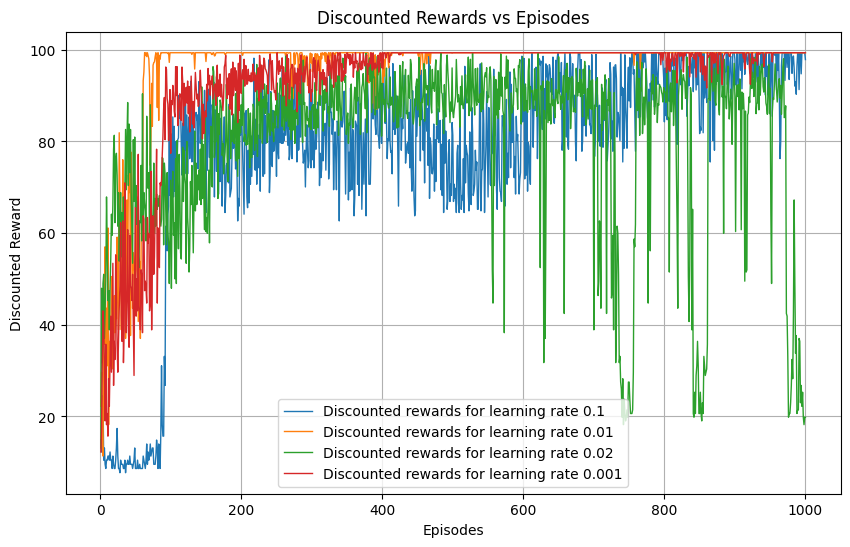

In [68]:

import matplotlib.pyplot as plt

# Generate sample data for discounted rewards
episodes = np.arange(1, 1001)

# Plot discounted rewards for different learning rates
plt.figure(figsize=(10, 6))
plt.plot(episodes, all_rewards_1, label='Discounted rewards for learning rate 0.1', linewidth=1)
plt.plot(episodes, all_rewards_2, label='Discounted rewards for learning rate 0.01', linewidth=1)
plt.plot(episodes, all_rewards_3, label='Discounted rewards for learning rate 0.02', linewidth=1)
plt.plot(episodes, all_rewards_4, label='Discounted rewards for learning rate 0.001', linewidth=1)

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Discounted Reward')
plt.title('Discounted Rewards vs Episodes')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


**ANS 4 :**

For learning rate = 0.01 we see early convergence therefore using its policy to compute the average reward we get

In [90]:
cummulative_disc_rewards = np.array([])

for i in range(5):
    total_reward, rewards, states, actions, probs = run_episode(env, policy_2)
    disc_reward = policy_2.discount_rewards(rewards)
    cummulative_disc_rewards=np.append(cummulative_disc_rewards,disc_reward[0])
print(cummulative_disc_rewards)
print("Average Reward over 5 episodes: ", np.mean(cummulative_disc_rewards))

[99.3429517 99.3429517 99.3429517 99.3429517 99.3429517]
Average Reward over 5 episodes:  99.34295169575849


**ANS 5**:  **REINFORCE algorithm with baseline**

In [69]:
env.reset()

(array([-0.0120873 ,  0.025007  ,  0.01390016, -0.03004446], dtype=float32),
 {})

In [70]:
import numpy as np

class ReinforceWithBaseline:
    def __init__(self, theta, weight, alpha_theta, alpha_weight, gamma):
        # Initialize parameters theta, weight, learning rate alpha_theta, alpha_weight, and discount factor gamma
        self.theta = theta
        self.weight = weight
        self.gamma = gamma
        self.alpha_theta = alpha_theta
        self.alpha_weight = alpha_weight

    def softmax(self, x):
        # Compute the softmax function
        for i in range(len(x)):
            if x[i] >= 100:
                x[i] = 100 
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x)

    def calculate_probabilities(self, x):
        # Compute action probabilities based on policy
        y = np.dot(self.theta, x.T)
        probabilities = self.softmax(y)
        return probabilities
    
    def choose_action(self, x):
        # Choose action based on probabilities
        probabilities = self.calculate_probabilities(x)
        action = np.random.choice([0, 1], p=probabilities)
        return action, probabilities[action]
    
    def compute_gradient_log_p(self, x, action):
        # Compute the gradient of log probabilities
        y0 = np.zeros((2,4))
        y1 = np.zeros((2,4))
        y0[0] = x
        y1[1] = x
        z = np.dot(self.theta,x.T)
        grad_log_p = 0
        if action == 0:
            grad_log_p = y0 - y0 * (self.softmax(z)[0]) - (y1 * self.softmax(z)[1])
        else:
            grad_log_p = y1 - y0 * (self.softmax(z)[0]) - (y1 * self.softmax(z)[1])
        return grad_log_p
    
    def discount_rewards(self, rewards):
        # Calculate discounted rewards
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.gamma + rewards[i]
            discounted_rewards[i] = cumulative_rewards
        return discounted_rewards
    
    def update_policy(self, rewards, states, actions):
        # Update policy parameters
        discounted_rewards = self.discount_rewards(rewards)
        for t in range(len(rewards)):
            delta = discounted_rewards[t] - (self.weight @ states[t])
            self.weight += self.alpha_weight * delta * states[t]
            self.theta += self.alpha_theta * ((self.gamma ** t) * delta * (discounted_rewards[t] * self.compute_gradient_log_p(states[t], actions[t])))
        return discounted_rewards[0]


In [71]:
def train_reinforce_with_baseline(theta, weight, alpha_theta, alpha_weight, gamma, Policy, MAX_EPISODES=1000):
    episode_rewards = []
    policy = Policy(theta, weight, alpha_theta, alpha_weight, gamma)

    for i in range(MAX_EPISODES):
        total_reward, rewards, states, actions, probabilities = run_episode(env, policy)
        disc_rewards = policy.update_policy(rewards, states, actions)
        episode_rewards.append(disc_rewards)
        
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ", end="\r")

    return episode_rewards, policy

In [72]:
theta1 = np.random.rand(2,4)
weight1 = np.random.rand(1,4)
alpha_theta = 0.002 
alpha_weight = 0.02
discount_factor = 0.99

base_rewards_1, policy_base_1 = train_reinforce_with_baseline(theta1, weight1, alpha_theta, alpha_weight, discount_factor, ReinforceWithBaseline)

In [97]:
theta2 = np.random.rand(2,4)
weight2 = np.random.rand(1,4)
alpha_theta = 0.09
alpha_weight = 0.04
discount_factor = 0.99
base_rewards_2, policy_base_2 = train_reinforce_with_baseline(theta2, weight2, alpha_theta, alpha_weight, discount_factor, ReinforceWithBaseline)

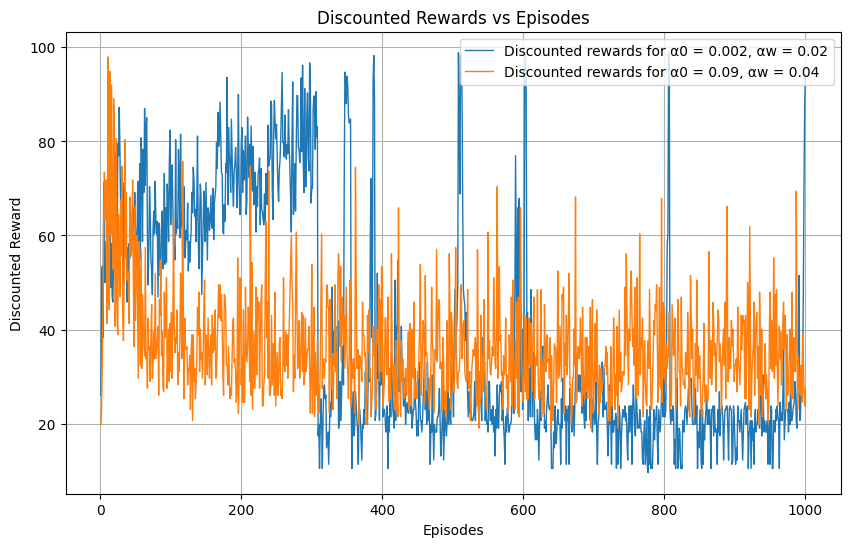

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data for discounted rewards
# Assuming we have 3 sets of discounted rewards for 1000 episodes each
episodes = np.arange(1, 1001)  # Assuming episodes range from 1 to 1000

# Plot the line graphs
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(episodes, base_rewards_1, label='Discounted rewards for α0 = 0.002, αw = 0.02', linewidth=1)  # Plot first set of discounted rewards
plt.plot(episodes, base_rewards_2, label='Discounted rewards for α0 = 0.09, αw = 0.04', linewidth=1)  # Plot second set of discounted rewards

# Add labels and title
plt.xlabel('Episodes')
plt.ylabel('Discounted Reward')
plt.title('Discounted Rewards vs Episodes')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

**ANS 6:**

For REINFORCE without baseline, policy_2 (i.e. $\alpha$ =0.01) is best converging than others <br> For REINFORCE with baseline, policy_base_1
(i.e. $\alpha$ $\theta$ =0.002 and $\alpha$ w=0.02) is best converging than others
Therefore comparing these training policy we get

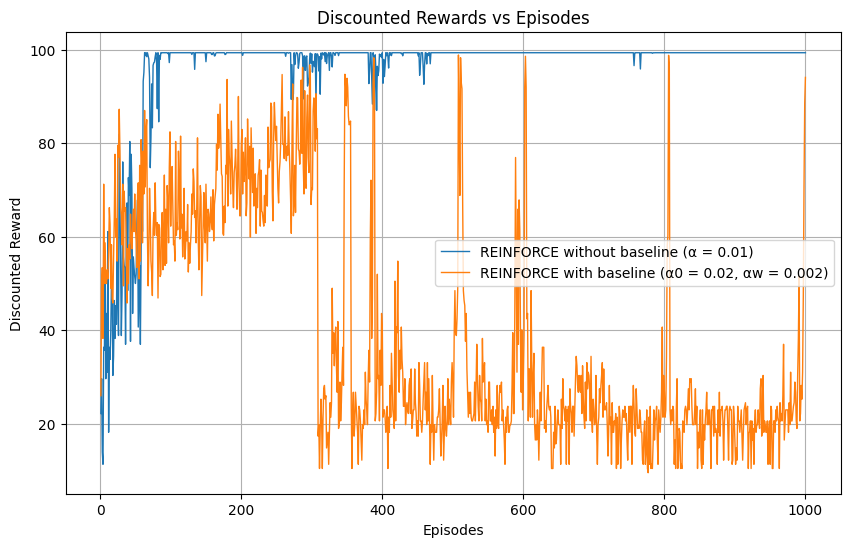

In [102]:
import numpy as np
import matplotlib.pyplot as plt

episodes = np.arange(1, 1001)

plt.figure(figsize=(10, 6)) 
plt.plot(episodes, all_rewards_2, label='REINFORCE without baseline (α = 0.01)', linewidth=1)
plt.plot(episodes, base_rewards_1, label='REINFORCE with baseline (α0 = 0.02, αw = 0.002)', linewidth=1)  
plt.xlabel('Episodes')
plt.ylabel('Discounted Reward')
plt.title('Discounted Rewards vs Episodes')
plt.legend()
plt.grid(True)
plt.show()